In [1]:
from train import main
import torch
import torch_geometric
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pylab
import matplotlib
import numpy as np
import networkx as nx

In [2]:
import datasets

model, config, train_loader, test_loader = main(dict(resume="3581ahp7", save_path="models/dummy.pt"), use_wandb=False, num_epochs=0)
model.eval()
num_hops = len(config.gnn_sizes)
device = torch.device(config.device)
final_emb_dim = config.gnn_sizes[-1]
dataset_wrapper = datasets.from_name(config.dataset)

0it [00:00, ?it/s]


In [4]:
for data in test_loader:
    break
data.cuda()

DataBatch(edge_index=[2, 2142], x=[980, 7], edge_attr=[2142, 4], y=[57], batch=[980], ptr=[58])

In [5]:
out, x_out, theta, h = model(data.x, data.edge_index, data.batch)

In [6]:
classes = torch.argmax(out, dim=-1)
theta_class = theta[data.batch, classes]
# check if shared theta network
if theta.shape[1] == 1:
    theta_class = theta.squeeze(1)
else:
    # [num_nodes_total]: theta corresponding to the chosen class for this sample for each node
    theta_class = theta[torch.arange(theta.shape[0]), classes[data.batch]].shape





IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [980], [57]

In [3]:
h_all = torch.empty(0, 1, device=config.device)
batch_all = torch.empty(0, device=config.device, dtype=torch.long)
x_all = torch.empty(0, model.input_dim, device=config.device)
x_out_all = torch.empty(0, final_emb_dim, device=config.device)
y_all = torch.empty(0, device=config.device, dtype=torch.long)
edge_index_all = torch.empty(2, 0, device=config.device, dtype=torch.long)
out_all = torch.empty(0, model.output_dim, device=config.device)
num_samples = 0
for data in test_loader:
    data.cuda()
    out, x_out, theta, h = model(data.x, data.edge_index, data.batch)
    h_all = torch.cat((h_all, h), dim=0)
    batch_all = torch.cat((batch_all, data.batch + num_samples), dim=0)
    x_all = torch.cat((x_all, data.x), dim=0)
    x_out_all = torch.cat((x_out_all, x_out), dim=0)
    y_all = torch.cat((y_all, data.y), dim=0)
    edge_index_all = torch.cat((edge_index_all, data.edge_index + num_samples), dim=1)
    out_all = torch.cat((out_all, out), dim=0)
    num_samples += len(data)

h_all = h_all.detach().cpu().numpy()
batch_all = batch_all.detach().cpu().numpy()
x_all = x_all.detach().cpu().numpy()
x_out_all = x_out_all.detach().cpu().numpy()
y_all = y_all.detach().cpu().numpy()
y_all_nodes = y_all[batch_all]
edge_index_all = edge_index_all.detach().cpu().numpy()
y_pred_all = torch.argmax(out_all, dim=1).detach().cpu().numpy()
out_all = out_all.detach().cpu().numpy()


C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


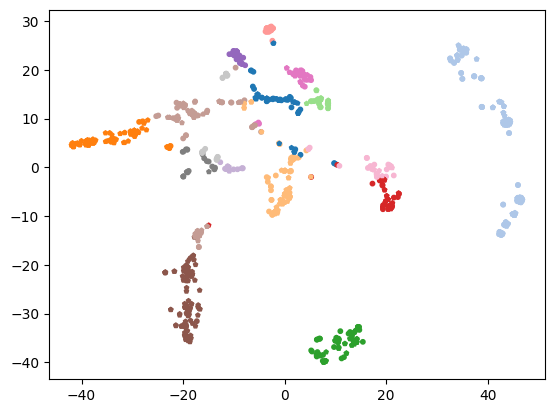

In [35]:
K = 16
# [num_nodes_total, x, y] (PCA or t-SNE)
coords = TSNE(n_components=2).fit_transform(X=x_out_all)
kmeans = KMeans(n_clusters=K).fit(X=x_out_all)
# [num_nodes_total] with integer values between 0 and K/num_clusters/num_concepts
clusters = kmeans.labels_

colors = np.array([matplotlib.colors.rgb2hex(c) for c in pylab.get_cmap("tab20").colors])
markers = ["o", "p", "s", "P", "*", "D", "^", "+", "x"]

fig, ax = plt.subplots()
for i in range(model.output_dim):
    # Note, we could also evaluate how the model classifies (y_pred_all) instead of the ground truth (y_all) for explainability
    ax.scatter(coords[y_all_nodes == i, 0], coords[y_all_nodes == i, 1], c=colors[clusters[y_all_nodes == i]], marker=markers[i], s=10)

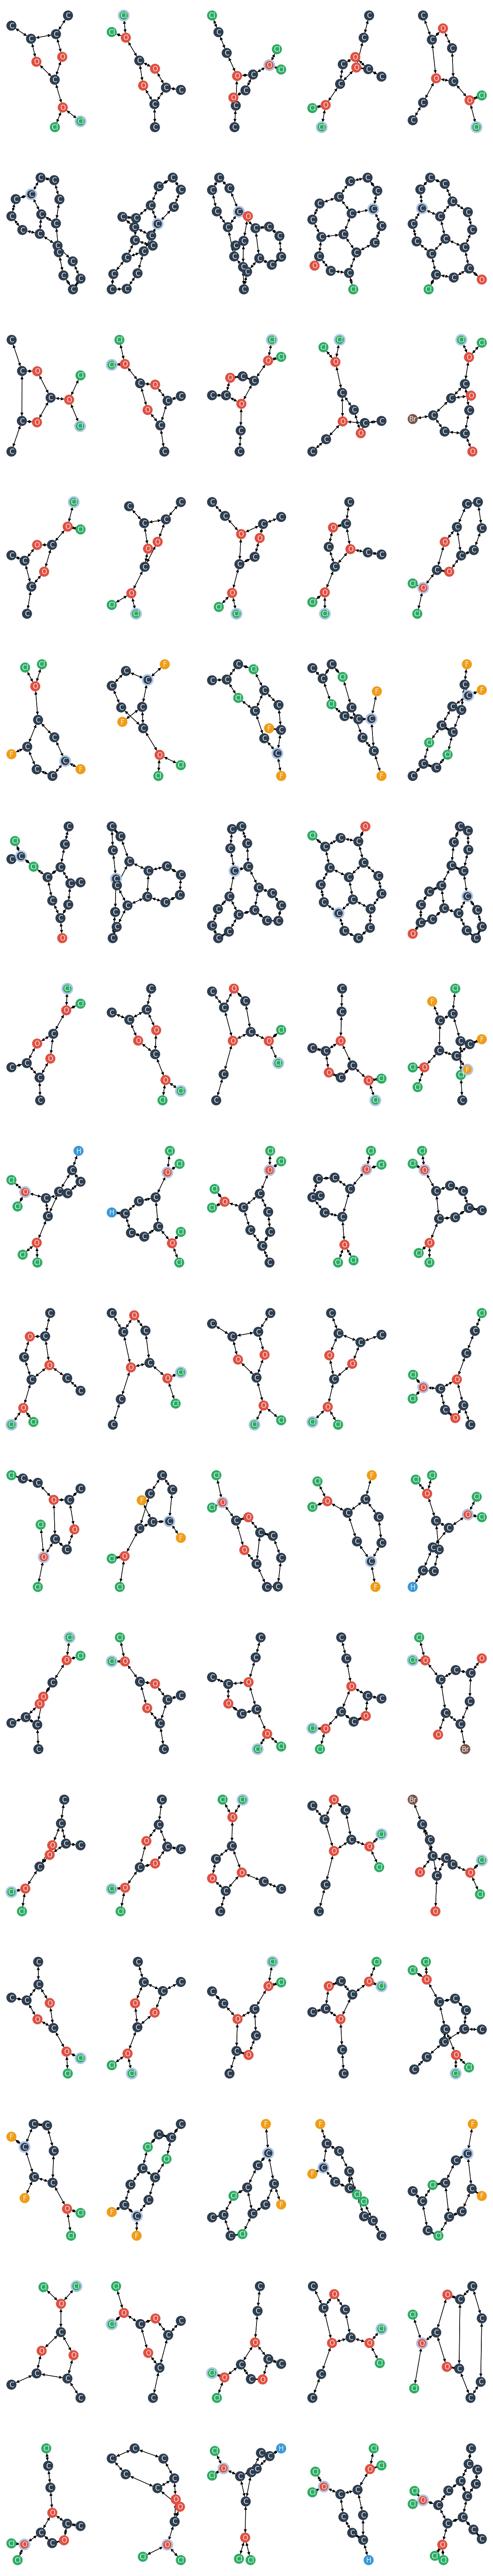

In [36]:
num_plots = 5
fig, axes = plt.subplots(K, num_plots, figsize=(15, K * 5))
for i in range(K):
    # indices of the num_plots nodes that are closest to the center of concept i
    _, indices = torch.topk(torch.norm(torch.tensor(kmeans.cluster_centers_[i:i+1, :] - x_out_all), dim=-1), k=num_plots, dim=0)
    for j in range(num_plots):
        draw_neighbourhood(axes[i][j], indices[j].item(), edge_index_all, x_all)


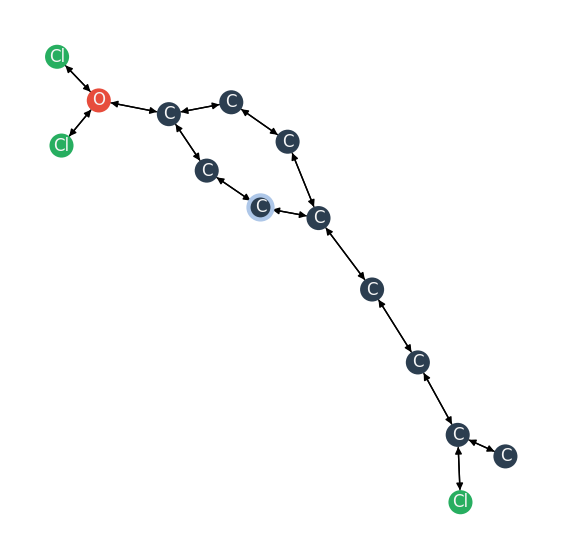

In [31]:

def draw_neighbourhood(ax, node_index: int, edge_index_all: np.ndarray, x_all: np.ndarray):
    ax.axis('off')
    subset, edge_index, mapping, _ = k_hop_subgraph(node_index, num_hops, torch.tensor(edge_index_all), relabel_nodes=True)
    g = torch_geometric.utils.to_networkx(Data(x=subset, edge_index=edge_index), to_undirected=False)
    highlight_mask = np.zeros(subset.shape[0], dtype=int)
    highlight_mask[mapping] = 1
    labels = dataset_wrapper.get_node_labels(x_all[subset])
    nx.draw(g, ax=ax, node_color=dataset_wrapper.get_node_colors(x_all[subset]), edgecolors=colors[highlight_mask],linewidths=3.0*highlight_mask, labels={i: labels[i] for i in range(labels.shape[0])}, font_color="whitesmoke")
fig, ax = plt.subplots(figsize=(7,7))
draw_neighbourhood(ax, 0, edge_index_all, x_all)

TypeError: topk(): argument 'input' (position 1) must be Tensor, not numpy.ndarray